/home/keigo/.local/lib/python3.6/site-packages/numpy/core/fromnumeric.py:87: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


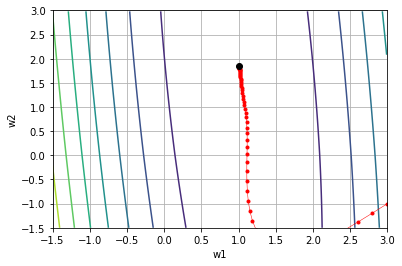

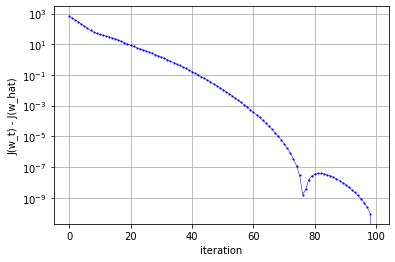

In [18]:
# requirement
import numpy as np
import matplotlib.pyplot as plt
import cvxpy as cv
import itertools

class Adam:
    def __init__(self):
        self.w_1 = np.arange(-1.5,3,0.01)
        self.w_2 = np.arange(-1.5,3,0.02)
        self.W1, self.W2 = np.mgrid[-1.5:3:0.01, -1.5:3:0.02]
        # 評価関数値
        self.Value = np.zeros((len(self.w_1), len(self.w_2)))
        # 重み行列
        self.A = np.array([[250, 15],[15, 4]])
        # 平均
        self.mu = np.array([[1],[2]])
        # 初期値
        self.x_init = np.array([[3], [-1]])
        # 正則化項係数
        self.lamda = 1.0
        # Adam parameter
        self.b1 = 0.7
        self.b2 = 0.99999
        self.ee = 1.0e-8
        self.aa = 0.2
        
    def calc_eval_fun(self):
        # 評価関数値の計算
        for i in range(len(self.w_1)):
            for j in range(len(self.w_2)):
                w = np.vstack([self.w_1[i], self.w_2[j]])
                self.Value[i, j] = np.dot(np.dot((w - self.mu).T, self.A), w - self.mu) + self.lamda * (np.abs(self.w_1[i]) + np.abs(self.w_2[j]))

    def proximal_operation(self, mu, q):
        x_projection = np.zeros(mu.shape)
        for i in range(len(mu)):
            if mu[i] > q:
                x_projection[i] = mu[i] - q
            else:
                if np.abs(mu[i]) < q:
                    x_projection[i] = 0
                else:
                    x_projection[i] = mu[i] + q
        return x_projection
    
    def main(self):
        # cvx
        w_lasso = cv.Variable((2, 1))
        J = cv.quad_form(w_lasso - self.mu, self.A) +  self.lamda * cv.norm(w_lasso, 1)
        objective = cv.Minimize(J)
        constraints = []
        prob = cv.Problem(objective, constraints)
        result = prob.solve(solver = cv.CVXOPT) 
        w_lasso = w_lasso.value

        plt.contour(self.W1, self.W2, self.Value)
        
        xt  = self.x_init
        # 値格納用配列
        x_history = []
        fvalues   = []
        g_history = []
        M = np.zeros((2, 1))
        V = np.zeros((2, 1))
        
        for t in range(1,101):
            x_history.append(xt.T)
            # 勾配
            grad = 2 * np.dot(self.A, xt - self.mu)
            M = self.b1 * M + (1 - self.b1) * grad
            V = self.b2 * V + (1 - self.b2) * (grad * grad)
            Mest = M / (1 - self.b1 ** t)
            Vest = V / (1 - self.b2 ** t)
            
            g_history.append(grad.T)
            
            rateProx = self.aa * np.ones((2, 1)) / (np.sqrt(Vest) + self.ee)
            # 重みの更新式
            xth = xt -  Mest * rateProx
            xt  = np.array([self.proximal_operation(xth[0], self.lamda * rateProx[0]),
                            self.proximal_operation(xth[1], self.lamda * rateProx[1])])
            # 評価関数値の計算
            J = np.dot(np.dot((xt - self.mu).T, self.A), (xt - self.mu)) + self.lamda * (np.abs(xt[0]) + np.abs(xt[1]))
            fvalues.append(J)
            
        fvalues   = np.vstack(fvalues)
        x_history = np.vstack(x_history)
        
        minfvalue = np.dot(np.dot((w_lasso - self.mu).T, self.A), (w_lasso - self.mu)) + self.lamda * np.sum(np.abs(w_lasso))
        minOfMin  = np.min([minfvalue, np.min(fvalues)])
        # Drow Graph
        plt.figure(1)
        plt.plot(x_history[:,0], x_history[:,1], 'ro-', markersize = 3, linewidth = 0.5)
        plt.plot(w_lasso[0], w_lasso[1], 'ko')
        plt.xlim(-1.5, 3)
        plt.ylim(-1.5, 3)
        plt.xlabel("w1")
        plt.ylabel("w2")
        plt.grid()
        
        plt.figure(2)
        plt.semilogy(fvalues - minOfMin, 'bs-', markersize = 1, linewidth = 0.5)
        plt.xlabel("iteration")
        plt.ylabel("J(w_t) - J(w_hat)")
        plt.grid()
    
ADAM = Adam()
ADAM.calc_eval_fun()
ADAM.main()